# Is apartment-type property cheaper than house-type on Airbnb?


## Introduction


## Preliminary Results

In [62]:
library(tidyverse)
library(tidymodels)
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)
library(digest)
library(grid)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [54]:
# read data
Airbnb <- read.csv("https://raw.githubusercontent.com/takumihoriba/stat201-project/main/data/train.csv") 
head(Airbnb)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,⋯,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Essentials,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",3,1,Real Bed,strict,True,⋯,40.69652,-73.99162,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100,https://a0.muscache.com/im/pictures/6d7cbbf7-c034-459c-bc82-6522c957627c.jpg?aki_policy=small,11201,1,1
2,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""Smoke detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",7,1,Real Bed,strict,True,⋯,40.76612,-73.98904,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93,https://a0.muscache.com/im/pictures/348a55fe-4b65-452a-b48a-bfecb3b58a66.jpg?aki_policy=small,10019,3,3
3,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air conditioning"",Kitchen,Breakfast,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_50""}",5,1,Real Bed,moderate,True,⋯,40.80811,-73.94376,The Garden Oasis,Harlem,10,92,https://a0.muscache.com/im/pictures/6fae5362-9e3a-4fa9-aa54-bbd5ea26538d.jpg?aki_policy=small,10027,1,3
4,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Kitchen,""Indoor fireplace"",""Buzzer/wireless intercom"",Heating,Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Fire extinguisher"",Essentials}",4,1,Real Bed,flexible,True,⋯,37.77200,-122.43162,Beautiful Flat in the Heart of SF!,Lower Haight,0,NA,https://a0.muscache.com/im/pictures/72208dad-9c86-41ea-a735-43d933111063.jpg?aki_policy=small,94117.0,2,2
5,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditioning"",Kitchen,""Elevator in building"",Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo}",2,1,Real Bed,moderate,True,⋯,38.92563,-77.03460,Great studio in midtown DC,Columbia Heights,4,40,,20009,0,1
6,12422935,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Fire extinguisher"",Essentials,Hangers,""Laptop friendly workspace""}",2,1,Real Bed,strict,True,⋯,37.75316,-122.42953,Comfort Suite San Francisco,Noe Valley,3,100,https://a0.muscache.com/im/pictures/82509143-4b21-44eb-a556-e3c1e0afac60.jpg?aki_policy=small,94131,1,1


In [55]:
#Clean and wrangle the dataset into a tidy format
set.seed(320)
#choose needed column
Airbnb_tidy <- Airbnb |> select(log_price, property_type) |> filter(property_type %in% c("House", "Apartment")) 

nrow(Airbnb_tidy)
head(Airbnb_tidy)

[1] 65514

,log_price,property_type
,<dbl>,<chr>
1,5.010635,Apartment
2,5.129899,Apartment
3,4.976734,Apartment
4,6.620073,House
5,4.744932,Apartment
6,4.442651,Apartment


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



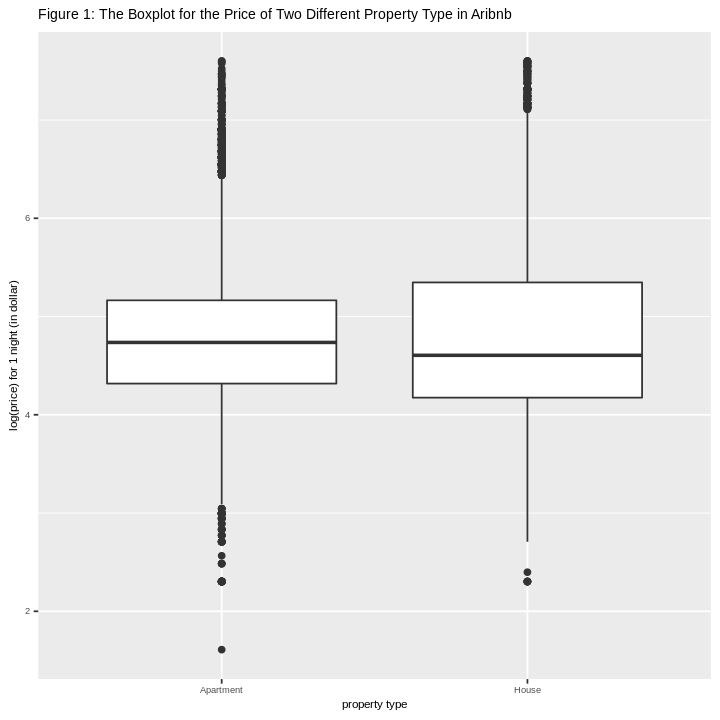

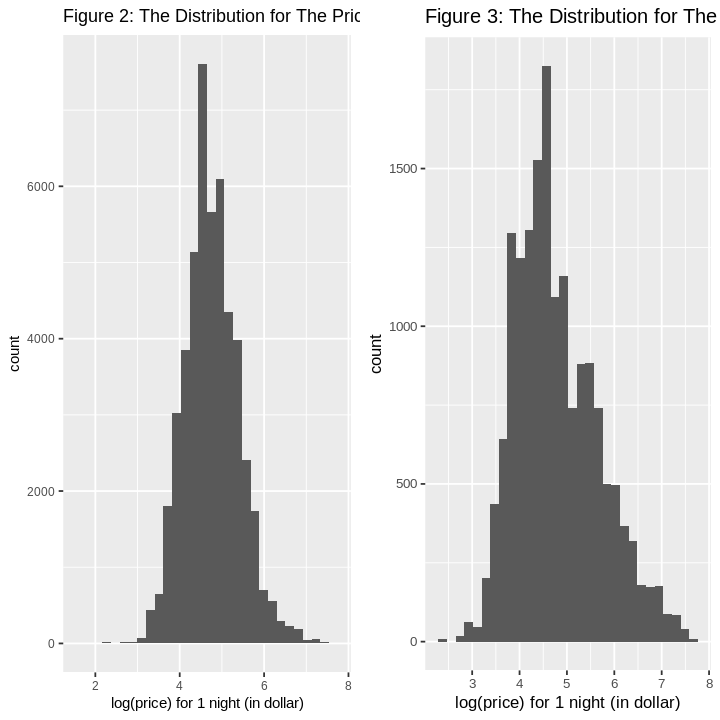

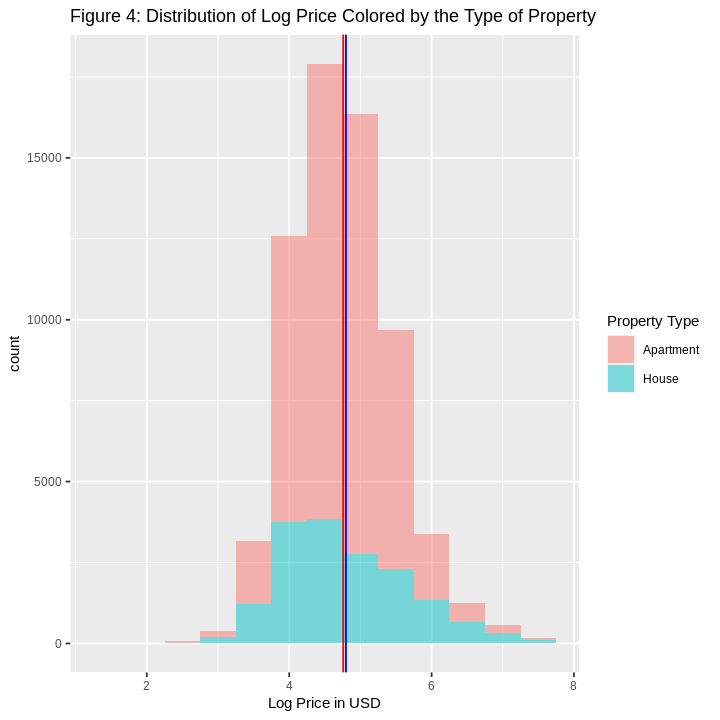

In [63]:
#Plot the relevant raw data
set.seed(320)

options(repr.plot.width = 6, repr.plot.height = 6)

#boxplot

log_price_boxplot <- ggplot(Airbnb_tidy,aes(x=property_type,y=log_price))+
                     geom_boxplot()+
                     labs(x="property type",y="log(price) for 1 night (in dollar)") +
                     theme(text=element_text(size=7))+
                     labs(title="Figure 1: The Boxplot for the Price of Two Different Property Type in Aribnb")
log_price_boxplot

Apartment_data <- Airbnb_tidy |> filter(property_type=="Apartment")

Apartment_distribution <- ggplot(Apartment_data,aes(x=log_price))+
                          geom_histogram()+
                          labs(x="log(price) for 1 night (in dollar)") +
                          theme(text=element_text(size=9))+
                          labs(title="Figure 2: The Distribution for The Price of Apartment in Aribnb")

 House_data <- Airbnb_tidy |> filter(property_type=="House")

House_distribution <- ggplot(House_data,aes(x=log_price))+
                          geom_histogram()+
                          labs(x="log(price) for 1 night (in dollar)") +
                          theme(text=element_text(size=10))+
                          labs(title="Figure 3: The Distribution for The Price of House in Aribnb")

sample_mean<- Airbnb_tidy |> group_by(property_type) |> summarize(sample_mean=mean(log_price))
compare_distribution <- Airbnb_tidy |>
                        ggplot(aes(x=log_price,fill=property_type))+
                        geom_histogram(binwidth=0.5,alpha=0.5)+
                        ggtitle("Figure 4: Distribution of Log Price Colored by the Type of Property")+
                        labs(fill="Property Type", x="Log Price in USD")+
                        theme(text=element_text(size=9))+
                        geom_vline(xintercept = sample_mean$sample_mean[1], color="red")+
                        geom_vline(xintercept = sample_mean$sample_mean[2],color="blue")

grid.arrange(Apartment_distribution,House_distribution,ncol=2)
compare_distribution

In [50]:
#estimate the parameter
set.seed(320)
prop_house_apartment <- Airbnb_tidy |>
group_by(property_type) |>
summarize(percent =  n()/nrow(Airbnb_tidy )) |>
arrange(desc(percent))
print("Table 1: the proportion of the property type") 
prop_house_apartment



[1] "Table 1: the proportion of the property type"


property_type,percent
<chr>,<dbl>
Apartment,0.7479775
House,0.2520225


In [51]:
set.seed(320)
Airbnb_summary <- Airbnb_tidy %>%  summary()
print("Table 2: summary") 
Airbnb_summary


[1] "Table 2: summary"


   log_price     property_type     
 Min.   :1.609   Length:65514      
 1st Qu.:4.277   Class :character  
 Median :4.700   Mode  :character  
 Mean   :4.768                     
 3rd Qu.:5.193                     
 Max.   :7.600                     

In [52]:
set.seed(320)
estimates<- Airbnb_tidy %>%
            group_by(property_type) %>%
            summarize(mean = mean(log_price),sd = sd(log_price))
print("Table 3: mean and sd value for aribnb dataset") 
estimates

[1] "Table 3: mean and sd value for aribnb dataset"


property_type,mean,sd
<chr>,<dbl>,<dbl>
Apartment,4.758850,0.6408249
House,4.797114,0.8758650


Define notations as follows:

- $\mu_h =$  population mean log price of house type listings
- $\mu_a =$ population mean log price of apartment type listings
- $x_h =$  sample mean log price of house type listings
- $x_a =$ sample mean log price of apartment type listings
- $\delta = \mu_h - \mu_a$
- $d = x_h - x_a$
- Null hypothesis $H_0: \delta = 0$
- Alternative hypothesis $H_a: \delta >0$


We observe $x_h > x_a \text{ which implies  } d > 0$.

## Methods: Plan

## References